In [1]:
# Required by Google Colab
!pip install qiskit qiskit_nature pyscf --quiet

### Define electronic molecule of $BeH_{2}$

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.algorithms import NumPyMinimumEigensolverFactory, GroundStateEigensolver, VQEUCCFactory, VQEUVCCFactory
from qiskit_nature.circuit.library import UCC, UCCSD, HartreeFock

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP

<ipython-input-2-5bdc434b74dd>:11: NatureDeprecationWarning: The qiskit_nature.algorithms.excited_state_solvers package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.excited_state_solvers package.
  from qiskit_nature.algorithms import NumPyMinimumEigensolverFactory, GroundStateEigensolver, VQEUCCFactory, VQEUVCCFactory
<ipython-input-2-5bdc434b74dd>:11: NatureDeprecationWarning: The qiskit_nature.algorithms.pes_sampler package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release . Please refer to 'https://github.com/Qiskit/qiskit-nature/issues/750' for additional information regarding 'extrapolators'.
  from qiskit_nature.algorithms import NumPyMinimumEigensolverFactory, GroundStateEigensolver, VQEUCCFactory, VQEUVCCFactory


In [3]:
"""
This block is only being used to debug some of the properties and figure out which orbitals should be removed

It appears we can limit the number of orbitals to 8, before the two qubit reduction, which would leave us with 6 qubits
"""
molecule = Molecule(geometry=[['H', [0., 0., -1.7]],
                                ['Be', [0., 0., 0.]],
                                ['H', [0., 0., 1.7]],
                                ], charge=0, multiplicity=1)

driver = ElectronicStructureMoleculeDriver(molecule, basis='sto6g', driver_type=ElectronicStructureDriverType.PYSCF)

freezeCoreTransformer = FreezeCoreTransformer(True, remove_orbitals=[3,4])
problem = ElectronicStructureProblem(driver, transformers=[freezeCoreTransformer])
print(problem.second_q_ops()['ElectronicEnergy'].to_list())
print(problem.num_spin_orbitals)
print(problem.num_particles)

[('+_0 -_0', -1.349706994640098), ('+_0 -_2', -0.0019225510542002888), ('+_1 -_1', -1.3389248976003085), ('+_1 -_3', -0.024252894160502934), ('+_2 -_0', -0.001922551054201291), ('+_2 -_2', -1.0046213346580652), ('+_3 -_1', -0.024252894160503916), ('+_3 -_3', -0.8303795818876997), ('+_4 -_4', -1.349706994640098), ('+_4 -_6', -0.0019225510542002888), ('+_5 -_5', -1.3389248976003085), ('+_5 -_7', -0.024252894160502934), ('+_6 -_4', -0.001922551054201291), ('+_6 -_6', -1.0046213346580652), ('+_7 -_5', -0.024252894160503916), ('+_7 -_7', -0.8303795818876997), ('+_0 +_0 -_0 -_0', -0.18103739479829528), ('+_0 +_0 -_2 -_0', 0.005409296756138296), ('+_0 +_1 -_1 -_0', -0.07795868434193719), ('+_0 +_1 -_3 -_0', 0.018955992411498136), ('+_0 +_2 -_0 -_0', 0.005409296756138149), ('+_0 +_2 -_2 -_0', -0.04357559916282348), ('+_0 +_3 -_1 -_0', 0.018955992411498052), ('+_0 +_3 -_3 -_0', -0.029196801780112247), ('+_0 +_0 -_1 -_1', -0.07795868434193717), ('+_0 +_0 -_3 -_1', 0.018955992411498132), ('+_0 +_

In [4]:
# Define molecule BeH2
def qubit_op(distance, mapper = ParityMapper(), remove_orbitals=[]):
  molecule = Molecule(geometry=[['H', [0., 0., -distance]],
                                ['Be', [0., 0., 0.]],
                                ['H', [0., 0., distance]],
                                ], charge=0, multiplicity=1)

  # set up a PySCF driver at bondlength 1.7 Angstrom (distance)
  driver = ElectronicStructureMoleculeDriver(molecule, basis='sto6g', driver_type=ElectronicStructureDriverType.PYSCF)
    # Get properties

  # Potential future use if we need these params
  # properties = driver.run()
  # num_particles = (properties
  #                     .get_property("ParticleNumber")
  #                     .num_particles)
  # num_spin_orbitals = int(properties
  #                         .get_property("ParticleNumber")
  #                         .num_spin_orbitals)

  freezeCoreTransformer = FreezeCoreTransformer(True,remove_orbitals=remove_orbitals)
  problem = ElectronicStructureProblem(driver, transformers=[freezeCoreTransformer])

  qubit_converter = QubitConverter(mapper, two_qubit_reduction=True, z2symmetry_reduction='auto')
  return problem, qubit_converter

### Reference Ground State Energy

In [5]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

### VQE

In [6]:
# PennyLane Gang VQE
def plg_VQE(problem, qubit_converter, maxiter=50):

  params_history = []
  def callback(xk):
    return params_history.append(xk)

  # Choose optimizer
  optimizer = SLSQP(maxiter=maxiter, callback=callback)

  # Pick backend simulator for quantum instance
  backend_name = 'aer_simulator_statevector' # Wall time: maxiter=1 -> 7.77 s, maxiter=50 -> 16.9 s
  quantum_instance = QuantumInstance(backend = Aer.get_backend(backend_name))

  # Solve the VQE Problem
  solver = VQEUCCFactory(quantum_instance=quantum_instance, optimizer=optimizer)
  gs_solver = GroundStateEigensolver(qubit_converter, solver)
  result = gs_solver.solve(problem)

  return result

### VQE vs. Bond Distance

In [7]:
%%time

"""
Runtime is 4m meaning an average time of 15s for each bond distance

Note: the call to qubit_op is currently not removing orbitals, which will decrease runtime and increase accuracy
"""

# Bond distances between 0.5 and 2.0 inclusive
distances = np.linspace(0.5, 2.0, 16)
expected_energies = []
calculated_energies = []

# Solve VQE for each distance
for dist in distances:
  # get problem structure and qubit converter
  problem, qubit_converter = qubit_op(dist, ParityMapper())

  # Get the expected eigen energy
  expected = exact_solver(problem, qubit_converter).total_energies[0].real
  expected_energies.append(expected)

  # Get the calculated eigen energy
  calculated = plg_VQE(problem, qubit_converter).total_energies[0].real
  calculated_energies.append(calculated)


<ipython-input-5-e93a7ffae588>:3: NatureDeprecationWarning: The qiskit_nature.algorithms.ground_state_solvers.GroundStateEigensolver class is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.ground_state_solvers.GroundStateEigensolver class.
  calc = GroundStateEigensolver(converter, solver)


CPU times: user 3min 53s, sys: 58.8 s, total: 4min 52s
Wall time: 4min 14s


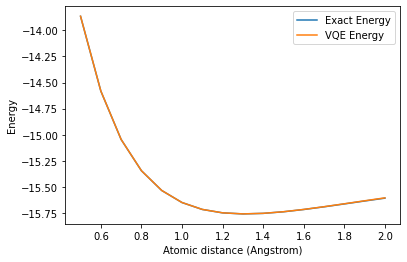

In [8]:
plt.plot(distances, expected_energies, label="Exact Energy")
plt.plot(distances, calculated_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

### Convergence for ideal bond distance

In [9]:
"""
After examining the result object from plg_VQE, I don't think we can see the individual iterations. 
It seems like the VQE objects in Qiskit are more of a black box
"""


dist = 1.3165
# get problem structure and qubit converter
problem, qubit_converter = qubit_op(dist, ParityMapper(), [3,4])

# Get the expected eigen energy
expected = exact_solver(problem, qubit_converter).total_energies[0].real

# Get the calculated eigen energy
calculated = plg_VQE(problem, qubit_converter).total_energies[0].real
print("Expected: ", expected)
print("VQE: ", calculated)

Expected:  -15.754166816797422
VQE:  -15.754137976063983


### Qubits tapering with Z2 symmetries reduction

In [10]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit

distance = 1.3165
#driver = PySCFDriver()
driver = PySCFDriver(
    atom=f"H 0 0 {-distance}; Be 0 0 0; H 0 0 {distance}",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM
)

problem = driver.run()
fermionic_op = problem.hamiltonian.second_q_op()

In [11]:
from qiskit_nature.second_q.mappers import QubitConverter
from qiskit_nature.second_q.mappers import JordanWignerMapper, BravyiKitaevMapper

#mapper = JordanWignerMapper()
#converter = QubitConverter(mapper)
#qubit_op = converter.convert(fermionic_op)
#print(qubit_op) # 14 qubits

from qiskit_nature.second_q.mappers import ParityMapper

#mapper = ParityMapper()
#converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)
#qubit_op = converter.convert(fermionic_op, num_particles=problem.num_particles)
#print(qubit_op) # 12 qubits

#converter = QubitConverter(JordanWignerMapper(), z2symmetry_reduction="auto")
#qubit_op = converter.convert(fermionic_op, sector_locator=problem.symmetry_sector_locator)
#print(qubit_op) # 9 qubits

#converter = QubitConverter(BravyiKitaevMapper(), z2symmetry_reduction="auto")
#qubit_op = converter.convert(fermionic_op, sector_locator=problem.symmetry_sector_locator)
#print(qubit_op) # 9 qubits

converter = QubitConverter(ParityMapper(), z2symmetry_reduction="auto")
qubit_op = converter.convert(fermionic_op, sector_locator=problem.symmetry_sector_locator)
print(qubit_op) # 9 qubits


-11.876704309546303 * IIIIIIIII
+ 2.216468351415816 * IIIIIIIIZ
+ 0.03221560115257366 * ZZIIZIZZX
+ 0.03221560115257366 * IIIIIIIIX
+ 0.02525720046328776 * IIIIIIZXX
+ 0.02525720046328776 * IIIIIIIYY
- 0.007832644684460429 * ZZIIZIZZZ
- 0.028047670326852608 * IIIIIIZXZ
- 0.028047670326852608 * ZZIIZIZXI
+ 0.02236916695576856 * ZIIZZIZII
- 0.010366493273611515 * ZZIIZIYYI
+ 0.010366493273611515 * IZIZIIYYI
- 0.29489690701094196 * IIZZIIIII
- 0.29489690701094196 * IZZIIIIII
- 0.26749659463211883 * IIIIIIZZI
+ 0.4825246181907547 * IIIIIIZII
- 2.216468351415821 * IIIIIZIII
+ 0.0322156011525735 * IIIIZXIII
+ 0.0322156011525735 * IIIIIXIII
+ 0.0252572004632877 * ZXXXXXIII
- 0.0252572004632877 * IYXXXYIII
+ 0.007832644684460195 * IIIIZZIII
+ 0.0280476703268526 * ZXXXXZIII
+ 0.0280476703268526 * IYXXYIIII
- 0.02236916695576919 * IIIZZIIII
+ 0.010366493273611523 * XXXXZIIII
+ 0.010366493273611523 * YXXYIIIII
- 0.26749659463211906 * ZZIIIIIII
- 0.4825246181907548 * ZIIIIIIII
- 0.1157820043362285